# Learning in LTN

This tutorial explains the concept of learning in Logic Tensor Networks.

In particular, it explains how to learn some language symbols (predicates, functions, constants) using the satisfaction
of a knowledge base as an objective.

For those unfamiliar with logic, a knowledge base is a container of logical formulas. Satisfying a knowledge base
as an objective means find a solution which maximize the satisfaction of all the formulas contained in the knowledge base.
In other words, we would find a representation for predicates, functions, and constants which increase the truth degree
of the formulas in the knowledge base.

This tutorial expects basic familiarity of the first two tutorials on LTN (grounding of symbols and connectives).

### LTN中的学习

本教程解释了在逻辑张量网络（Logic Tensor Networks）中的学习概念。

具体来说，它解释了如何使用知识库的满足度作为目标来学习一些语言符号（谓词、函数、常量）。

对于不熟悉逻辑的人来说，知识库是逻辑公式的容器。将满足知识库作为目标意味着找到一种解决方案，以最大化知识库中所有公式的满足度。换句话说，我们要找到谓词、函数和常量的表示形式，以提高知识库中公式的真值度。

本教程期望读者对前两个关于LTN的教程（符号的基础化和连接词）有基本的熟悉。

In [2]:
import torch
import numpy as np
import ltn
import matplotlib.pyplot as plt

## Classification with Nearest Neighbour

We use the following simple example to illustrate learning in LTN.

The domain is the square $[0,4] \times [0,4]$. We have some points in this domain, and we need to infer their classes.
In particular, we know the classes of only two examples. One example is of class $A$ and the other of class $B$.
The rest of the points are not labelled, but there are two assumptions:
- $A$ and $B$ are mutually exclusive,
- any two close points should share the same label.

In the following, we plot our dataset made of 19 points. We distinguish between classified and not classified examples.

当然，以下是您提供内容的中文翻译：

## 使用最近邻分类

我们使用以下简单的示例来说明在 LTN 中的学习。

域是正方形 $[0,4] \times [0,4]$。我们在这个域中有一些点，需要推断它们的类别。
特别地，我们只知道两个示例的类别。一个示例属于类别 $A$，另一个示例属于类别 $B$。
其余的点没有标签，但有两个假设：
- $A$ 和 $B$ 是互斥的，
- 任何两个相近的点应该共享相同的标签。

在下面的部分中，我们绘制了由 19 个点组成的数据集。我们区分了已分类和未分类的示例。

[0.4 1.2 2.2 1.7 0.5 0.3 1.3 0.9 3.4 3.2 3.2 2.7 3.5 3.3 3.3 1.9 1.3 3.3
 3.9]
(19,)


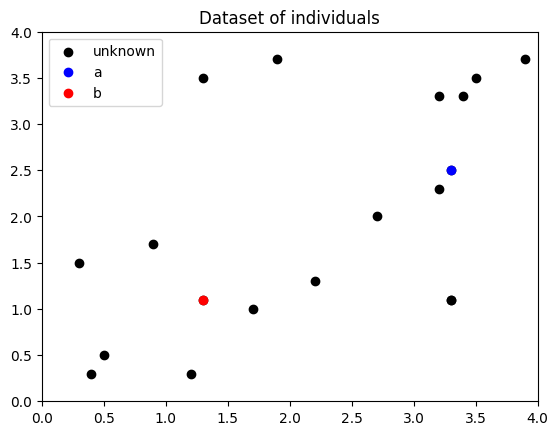

In [3]:
# 一些解释在3.md的## 1中。
points = np.array(
        [[0.4,0.3], [1.2,0.3], [2.2,1.3], [1.7,1.0], [0.5,0.5], [0.3, 1.5], [1.3, 1.1], [0.9, 1.7],
        [3.4,3.3], [3.2,3.3], [3.2,2.3], [2.7,2.0], [3.5,3.5], [3.3, 2.5], [3.3, 1.1], [1.9, 3.7], [1.3, 3.5],
        [3.3, 1.1],[3.9, 3.7]]) # 返回值类型为numpy.ndarray
# np.array 函数将列表转换为 numpy 数组，方便后续的数值运算和操作。
point_a = [3.3, 2.5]
point_b = [1.3, 1.1]
fig, ax = plt.subplots() # 返回值类型为Figure和AxesSubplot
# plt.subplots() 创建一个包含一个图形和一个子图的图形对象。返回一个包含图形和子图对象的元组。fig 是图形对象，ax 是子图对象，允许我们在子图上绘制数据。
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)
# ax.scatter 函数绘制散点图
ax.scatter(points[:,0], points[:,1], color="black", label="unknown")
ax.scatter(point_a[0], point_a[1], color="blue", label="a")
ax.scatter(point_b[0], point_b[1], color="red", label="b")
# 后面的这两个蓝红的点把前面的黑色点覆盖了
ax.set_title("Dataset of individuals")
plt.legend(); # plt.legend() 显示图例。返回值类型为Legend，即图例对象。

print(points[:,0])
print(points[:,0].shape)

plt.show() # 显示图形对象，在 Jupyter Notebook 中可以不需要调用 plt.show()，但在其他环境中需要调用 plt.show()。图形对象即为前面的fig。图形对象的类型是Figure。

## Definition of knowledge base

First, we need to define a membership predicate $C(x,l)$, where $x$ is an individual (point) and $l$ is a one-hot label
denoting one of the two classes (10 for class $A$ and 01 for class $B$).

$C$ is approximated by a simple MLP (Multi-Layer Perceptron). The last layer, that computes probabilities per class, uses a `softmax` activation, ensuring that the classes are mutually-exclusive.

We define the knowledge base $\mathcal{K}$ with the following rules:
\begin{align}
& C(a,l_a)\\
& C(b,l_b)\\
\forall x_1,x_2,l\ \big(\mathrm{Sim}(x_1,x_2) & \rightarrow \big(C(x_1,l)\leftrightarrow C(x_2,l)\big)\big)
\end{align}

where:
- $a$ and $b$ the two individuals already classified;
- $x_1$ and $x_2$ are variables ranging over all individuals;
- $l_a$ and $l_b$ are the one-hot labels for $A$ and $B$;
- $l$ is a variable ranging over the labels;
- $\mathrm{Sim}$ is a predicate measuring similarity between two points and defined as $\mathcal{G}(\mathrm{Sim}):\vec{u},\vec{v}\mapsto \exp(-\|\vec{u}-\vec{v} \|^2)$.

The objective is to learn the predicate $C$ in such a way to maximize the satisfaction of $\mathcal{K}$.

If $\theta$ denotes the set of trainable parameters, the task is:
\begin{align}
\theta^\ast = \mathrm{argmax}_{\theta\in\Theta}\ \mathrm{SatAgg}_{\phi\in\mathcal{K}} \text{ } \mathcal{G}_{\theta}(\phi)
\end{align}

where $\mathrm{SatAgg}$ is an operator that aggregates the truth values of the formulas in $\mathcal{K}$
(if there are more than one formula).

In order to define the knowledge base in LTN, we need to define our predicates, variables, and constants first.

In the
following, the names of predicates, variables, and constants are the same used in the problem formulation above.

## 知识库的定义（其中相关的公式、符号解释在3.md的## 2中）

首先，我们需要定义一个成员谓词 $C(x, l)$，其中 $x$ 是一个个体（点），$l$ 是一个表示两类之一的独热标签（10表示类 $A$ 和01表示类 $B$）。

$C$ 由一个简单的多层感知器（MLP）近似。最后一层使用 `softmax` 激活函数来计算每类的概率，确保类别是互斥的。

我们通过以下规则定义知识库 $\mathcal{K}$：
\begin{align}
& C(a, l_a) \\
& C(b, l_b) \\
\forall x_1, x_2, l\ \big(\mathrm{Sim}(x_1, x_2) & \rightarrow \big(C(x_1, l) \leftrightarrow C(x_2, l)\big)\big)
\end{align}

其中：
- $a$ 和 $b$ 是已经分类的两个个体；
- $x_1$ 和 $x_2$ 是在所有个体上范围的变量；
- $l_a$ 和 $l_b$ 是 $A$ 和 $B$ 的独热标签；
- $l$ 是在标签上范围的变量；
- $\mathrm{Sim}$ 是一个度量两个点之间相似性的谓词，定义为 $\mathcal{G}(\mathrm{Sim}):\vec{u}, \vec{v} \mapsto \exp(-\|\vec{u} - \vec{v}\|^2)$。

目标是学习谓词 $C$，以最大化 $\mathcal{K}$ 的满足度。

如果 $\theta$ 表示可训练参数的集合，则任务是：
\begin{align}
\theta^\ast = \mathrm{argmax}_{\theta \in \Theta}\ \mathrm{SatAgg}_{\phi \in \mathcal{K}} \text{ } \mathcal{G}_{\theta}(\phi)
\end{align}

其中 $\mathrm{SatAgg}$ 是一个聚合 $\mathcal{K}$ 中公式真值的操作符（如果有多个公式）。

为了在 LTN 中定义知识库，我们需要首先定义我们的谓词、变量和常量。

在下面的定义中，谓词、变量和常量的名称与上述问题表述中使用的名称相同。

In [4]:
# Predicate C # 谓词C
class ModelC(torch.nn.Module):
    def __init__(self):
        super(ModelC, self).__init__()
        self.elu = torch.nn.ELU()
        self.softmax = torch.nn.Softmax(dim=1)
        self.dense1 = torch.nn.Linear(2, 5)
        self.dense2 = torch.nn.Linear(5, 5)
        self.dense3 = torch.nn.Linear(5, 2)

    def forward(self, x, l):
        """x: point, l: one-hot label""" # x: 点, l: one-hot标签
        x = self.elu(self.dense1(x))
        x = self.elu(self.dense2(x))
        prob = self.softmax(self.dense3(x))
        return torch.sum(prob * l, dim=1)

# C = ltn.Predicate(ModelC()) # 原来的写法会报错
C = ltn.Predicate(ModelC().to(ltn.device))

# Predicate Sim # 谓词Sim
Sim = ltn.Predicate(func=lambda u, v: torch.exp(-1. * torch.sqrt(torch.sum(torch.square(u - v), dim=1)))) # 这里这一个谓词感觉和离散里面的谓词不一样，它就是通过一个函数，输出两个向量的相似度，而且应该是不可学习的吧。不过或许也可以理解成是两个向量相似的一个置信度，这样的话，这个谓词的含义就是“这两个向量相似”，而这个谓词的置信度就是输出的值。

### 谓词Sim的定义

```python
# Predicate Sim # 谓词Sim
Sim = ltn.Predicate(func=lambda u, v: torch.exp(-1. * torch.sqrt(torch.sum(torch.square(u - v), dim=1))))
```

#### 详细解释

1. **定义谓词 `Sim`**：
   - 使用 `lambda` 函数定义相似性度量函数。
   - 函数输入为两个向量 `u` 和 `v`，输出为相似性度量值。
   ```python
   func=lambda u, v: torch.exp(-1. * torch.sqrt(torch.sum(torch.square(u - v), dim=1)))
   ```
   - 计算两个向量之间的欧氏距离的平方和，并取负的指数：
     - `torch.square(u - v)`：计算两个向量的差的平方。
     - `torch.sum(..., dim=1)`：对每个向量对的平方差求和。
     - `torch.sqrt(...)`：取平方和的平方根。
     - `torch.exp(-1. * ...)`：取负的指数。

2. **使用 `ltn.Predicate` 包装成谓词 `Sim`**：
   ```python
   Sim = ltn.Predicate(func=...)
   ```

通过这种方式，我们定义了两个谓词 `C` 和 `Sim`，分别用于表示分类和相似性度量。希望这些解释能帮助您理解代码的逻辑。如果还有其他问题，请随时提问。

In [5]:
# variables and constants # 变量和常量
x1 = ltn.Variable("x1", torch.tensor(points)) # x1里面有19个点
x2 = ltn.Variable("x2", torch.tensor(points)) # x2里面有19个点
a = ltn.Constant(torch.tensor([3.3, 2.5]))
b = ltn.Constant(torch.tensor([1.3, 1.1]))
l_a = ltn.Constant(torch.tensor([1, 0]))
l_b = ltn.Constant(torch.tensor([0, 1]))
l = ltn.Variable("l", torch.tensor([[1, 0], [0, 1]]))

In the following, we plot the similarity of each point in the dataset with the point $a$. Lower the similarity, thinner the line
which connect the points.

下面，我们绘制数据集中每个点与点 $a$ 的相似度。相似度越低，连接点的线条越细。

similarities_to_a:
 tensor([0.0263, 0.0478, 0.1963, 0.1116, 0.0320, 0.0423, 0.0870, 0.0797, 0.4465,
        0.4465, 0.7996, 0.4579, 0.3607, 1.0000, 0.2466, 0.1582, 0.1069, 0.2466,
        0.2614], device='cuda:0')
similarities_to_a.shape:
 torch.Size([19])
type(enumerate(similarities_to_a)):
 <class 'enumerate'>
enumerate(similarities_to_a):
enumerate(similarities_to_a):
 [(0, tensor(0.0263, device='cuda:0')), (1, tensor(0.0478, device='cuda:0')), (2, tensor(0.1963, device='cuda:0')), (3, tensor(0.1116, device='cuda:0')), (4, tensor(0.0320, device='cuda:0')), (5, tensor(0.0423, device='cuda:0')), (6, tensor(0.0870, device='cuda:0')), (7, tensor(0.0797, device='cuda:0')), (8, tensor(0.4465, device='cuda:0')), (9, tensor(0.4465, device='cuda:0')), (10, tensor(0.7996, device='cuda:0')), (11, tensor(0.4579, device='cuda:0')), (12, tensor(0.3607, device='cuda:0')), (13, tensor(1., device='cuda:0')), (14, tensor(0.2466, device='cuda:0')), (15, tensor(0.1582, device='cuda:0')), (16, tensor(0.

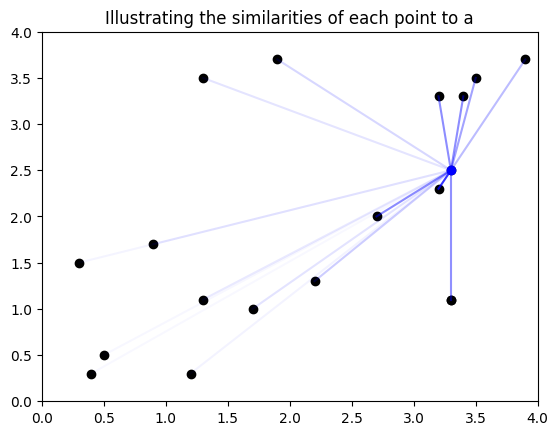

In [6]:
similarities_to_a = Sim(x1, a).value

print("similarities_to_a:\n", similarities_to_a)
print("similarities_to_a.shape:\n", similarities_to_a.shape)

fig, ax = plt.subplots()
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)
ax.scatter(points[:,0], points[:,1], color="black")

# ax.scatter(a.value[0], a.value[1], color="blue") # 原来的写法会报错
ax.scatter(a.value.detach().cpu()[0], a.value.detach().cpu()[1], color="blue")

ax.set_title("Illustrating the similarities of each point to a")
# for i, sim_to_a in enumerate(similarities_to_a): # 原来的写法会报错
#     plt.plot([points[i,0], a.value[0]], [points[i,1],a.value[1]], alpha=float(sim_to_a.numpy()), color="blue")

for i, sim_to_a in enumerate(similarities_to_a):
    plt.plot([points[i,0], a.value.detach().cpu()[0]], [points[i,1],a.value.detach().cpu()[1]], alpha=float(sim_to_a.detach().cpu().numpy()), color="blue")
# enumerate(similarities_to_a)：枚举 similarities_to_a，获取每个相似性值及其索引。
# plt.plot(连线的 x 坐标起点和终点,连线的 y 坐标起点和终点,设置线条的透明度,设置线条的颜色)

print("type(enumerate(similarities_to_a)):\n", type(enumerate(similarities_to_a))) #  <class 'enumerate'>
print("enumerate(similarities_to_a):\n", enumerate(similarities_to_a)) #  <enumerate object at 0x000001B1C12F5350>
print("enumerate(similarities_to_a):\n", list(enumerate(similarities_to_a)))

plt.show();

plt.plot(...)：绘制每个点与𝑎之间的连线：
[points[i,0], a.value.detach().cpu()[0]]：连线的 x 坐标起点和终点。
[points[i,1], a.value.detach().cpu()[1]]：连线的 y 坐标起点和终点。
alpha=float(sim_to_a.detach().cpu().numpy())：根据相似性值设置透明度，使相似性越高的连线越不透明。

For the connectives, we use the stable "product configuration" explained in the complementary notebook (2b-grounding-connectives.ipynb).

In particular, the operator for equivalence ($p \leftrightarrow q$) is implemented in LTN as $(p \rightarrow q)\land(q \rightarrow p)$, using
one operator for conjunction and one operator for implication. Such operator is available at `ltn.fuzzy_ops.Equiv`.

对于连结词，我们使用在补充笔记本 (2b-grounding-connectives.ipynb) 中解释的稳定 "乘积配置"。

特别地，等价 ($p \leftrightarrow q$) 运算符在 LTN 中实现为 $(p \rightarrow q) \land (q \rightarrow p)$，使用一个用于合取的运算符和一个用于蕴涵的运算符。这样的运算符在 `ltn.fuzzy_ops.Equiv` 中可用。

In [7]:
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Equiv = ltn.Connective(ltn.fuzzy_ops.Equiv(ltn.fuzzy_ops.AndProd(), ltn.fuzzy_ops.ImpliesReichenbach())) # 已经确定的是，等价是通过蕴涵和合取来实现的，但是具体的数字的计算，可以有多种方式，这里选择的蕴含和合取是AndProd和ImpliesReichenbach。
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=6), quantifier="e")

Now that we have defined our predicates, variables, and constants, we are ready for defining the knowledge base.

If there are several closed formulas in $\mathcal{K}$, their truth values need to be aggregated, and this is what the $\mathrm{SatAgg}$
operator does. Currently, $\mathrm{SatAgg}$ supports only closed formulas.

To be clear, a closed formula is a formula which does not have free variables appearing in it,
namely all the variables are quantified.

In LTN, the $\mathrm{SatAgg}$ operator is available at `ltn.fuzzy_ops.SatAgg`. The constructor `SatAgg()` takes as input
an aggregation operator, which is then used to aggregate the inputs when the operator is invoked. Specifically, the operator takes as
input a list of truth values of closed formulas and returns the aggregation of these values using the selected aggregator.

As `SatAgg` aggregator, we recommend using the generalized mean inspired operator `pMeanError`, already used to implement $\forall$. For this reason, the constructor
`SatAgg()` defines the operator using the `pMeanError`.
The hyper-parameter $p$ again allows flexibility in how strict the formula aggregation is ($p = 1$ corresponds to `mean`; $p \to +\inf$ corresponds to `min`).

In the following, we define the `SatAgg` operator and a training loop to learn our LTN model.

As shown, the `SatAgg` operator takes as input the formulas in our knowledge base and returns a truth value which is
interpreted as the satisfaction level of the entire knowledge base. Since we want to maximize this number, we need to
minimize $1 - SatAgg$, using gradient descent.

Notice that it is not needed to access the `value` attribute before giving the formulas to the `SatAgg` operator. This is because
the operator accepts `LTNObject` instances in input.

In the forward phase of the LTN, the truth values of the three formulas are computed, while in the backward phase the weights
of predicate $C$ are changed in such a way to minimize the loss function.

现在我们已经定义了我们的谓词、变量和常量，我们可以定义知识库了。

如果在 $\mathcal{K}$ 中有多个闭合公式，它们的真值需要聚合，这就是 $\mathrm{SatAgg}$ 操作符的作用。目前，$\mathrm{SatAgg}$ 仅支持闭合公式。

需要明确的是，闭合公式是指其中没有自由变量出现的公式，即所有变量都是量化的。

闭合公式是指在公式中没有自由变量出现的公式，即所有变量都是量化的。例如，$\forall x (P(x))$ 是一个闭合公式，因为 $x$ 是量化的。相反，$P(x)$ 不是一个闭合公式，因为 $x$ 是自由变量。

在 LTN 中，$\mathrm{SatAgg}$ 操作符可以在 `ltn.fuzzy_ops.SatAgg` 中找到。构造函数 `SatAgg()` 接受一个聚合操作符作为输入，然后在调用该操作符时使用该聚合操作符聚合输入。具体来说，该操作符接受一个闭合公式真值列表作为输入，并使用选定的聚合器返回这些值的聚合结果。

作为 `SatAgg` 聚合器，我们建议使用通用均值启发的操作符 `pMeanError`，它已经用于实现 $\forall$。因此，构造函数 `SatAgg()` 使用 `pMeanError` 定义了该操作符。
超参数 $p$ 再次允许公式聚合的严格程度具有灵活性（$p = 1$ 对应于 `mean`；$p \to +\infty$ 对应于 `min`）。

接下来，我们定义 `SatAgg` 操作符和一个训练循环来学习我们的 LTN 模型。

如图所示，`SatAgg` 操作符以我们的知识库中的公式作为输入，并返回一个真值，该真值被解释为整个知识库的满意度。由于我们希望最大化这个数值，我们需要使用梯度下降最小化 $1 - SatAgg$。

请注意，在将公式传递给 `SatAgg` 操作符之前，不需要访问 `value` 属性。这是因为该操作符接受 `LTNObject` 实例作为输入。

在 LTN 的前向阶段，计算三个公式的真值，而在反向阶段，谓词 $C$ 的权重会发生变化，以最小化损失函数。

In [8]:
# 在3.md的## 3中，有相关解释
# by default, SatAgg uses the pMeanError # 默认情况下，SatAgg使用pMeanError
sat_agg = ltn.fuzzy_ops.SatAgg() # todo-done:什么是闭合公式（closed formula）

# we need to learn the parameters of the predicate C # 我们需要学习谓词C的参数
optimizer = torch.optim.Adam(C.parameters(), lr=0.001) # optimizer是一个Adam类的实例，用于优化C的参数，学习率为0.001
# optimization:优化
# C.parameters()：获取谓词𝐶的参数，因为谓词C的类型是ModelC，而ModelC继承自torch.nn.Module，所以可以使用.parameters()方法获取参数。

for epoch in range(2000):
    optimizer.zero_grad() # 在每次反向传播之前，清零优化器的梯度。
    loss = 1. - sat_agg(
        C(a, l_a),
        C(b, l_b),
        Forall([x1, x2, l], Implies(Sim(x1, x2), Equiv(C(x1, l), C(x2, l))))
    )
    loss.backward() # 计算损失函数的梯度，用于反向传播。
    optimizer.step() # 使用计算得到的梯度更新谓词 𝐶 的参数。
    if epoch%200 == 0:
        print("Epoch %d: Sat Level %.3f "%(epoch, 1 - loss.item()))
print("Training finished at Epoch %d with Sat Level %.3f" %(epoch, 1 - loss.item()))

# 在训练的过程中，通过损失函数，让知识库中的逻辑表达式的满足度尽可能接近1，尽可能高。那就意味着，谓词中需要学习的参数，就尽可能往满足知识库的方向走，这样就能够学习到一个合适的谓词，用于分类。这个谓词，或者说这个谓词中的参数，就学会了知识库中的逻辑表达式，根据这些表达式，对数据进行分类。逻辑表达式给参数的学习提供了知识和指引，而不是向往常的机器学习，通过大量的已知的点和对应的类别来学习，这里是通过逻辑表达式来学习。

Epoch 0: Sat Level 0.594 
Epoch 200: Sat Level 0.868 
Epoch 400: Sat Level 0.949 
Epoch 600: Sat Level 0.953 
Epoch 800: Sat Level 0.954 
Epoch 1000: Sat Level 0.955 
Epoch 1200: Sat Level 0.955 
Epoch 1400: Sat Level 0.955 
Epoch 1600: Sat Level 0.955 
Epoch 1800: Sat Level 0.955 
Training finished at Epoch 1999 with Sat Level 0.955


After a few epochs, the system has learned to identify samples close to the point $a$ (resp. $b$) as belonging to class
$A$ (resp. $B$) based on the rules of the knowledge base.

In the following, we draw a plot showing that our LTN has been able to learn how to classify
the data points using the satisfaction of a knowledge base as an objective. The colour is brighter when predicate
$C$ is more satisfied. On the left, we see that $C$ correctly classifies points of class $A$, while on
the right we see it correctly classifies points of class $B$.

以下是您提供的内容的中文翻译：

经过几个训练周期后，系统已经学会根据知识库的规则，将接近点 $a$（或 $b$）的样本识别为属于类 $A$（或 $B$）。

在下面的内容中，我们绘制了一张图，显示我们的 LTN（逻辑张量网络）已经学会如何使用知识库的满足度作为目标来对数据点进行分类。颜色越亮，表示谓词 $C$ 的满足度越高。在左图中，我们看到 $C$ 正确分类了类 $A$ 的点，而在右图中，我们看到 $C$ 正确分类了类 $B$ 的点。

In [9]:
print("range(2000):\n", range(2000)) # range(0, 2000)
# 生成一个从 0 到 1999 的整数序列，用于迭代次数。
print("type(range(2000)):\n", type(range(2000))) # <class 'range'>

range(2000):
 range(0, 2000)
type(range(2000)):
 <class 'range'>


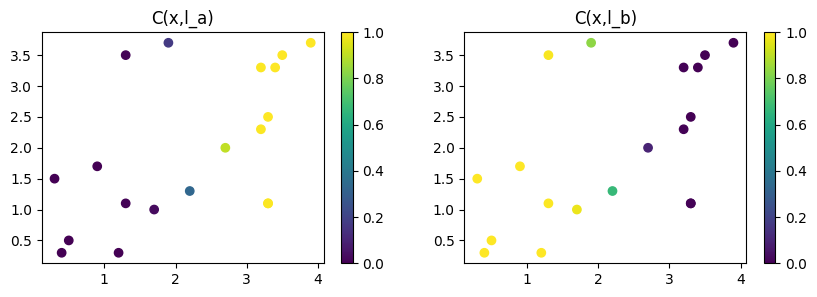

In [10]:
fig = plt.figure(figsize=(10, 3)) # 创建一个大小为 10x3 的图形对象，类型是Figure，并同时设置为了当前活动图形对象。
fig.add_subplot(1, 2, 1) # 为fig这个活动的图形对象添加子图。1, 2, 1表示将图形分为 1 行 2 列，当前子图位于第 1 个位置。1：表示图形对象中有1行子图。2：表示图形对象中有2列子图。1：表示这是第一个子图。
# 同时，把当前这个子图(AxesSubplot)设置为活动的子图。返回值类型是Axes。
# plt.scatter(x1.value[:, 0], x1.value[:, 1], c=C(x1, l_a).value.detach().numpy(), vmin=0, vmax=1) # 原来的写法会报错
plt.scatter(x1.value.detach().cpu()[:, 0], x1.value.detach().cpu()[:, 1], c=C(x1, l_a).value.detach().cpu().numpy(), vmin=0, vmax=1)
# c=C(x1, l_a).value.detach().cpu().numpy()：计算谓词 C(x1, l_a) 的值，并将其转换为 NumPy 数组。这个值将作为散点的颜色。
# vmin=0, vmax=1：设置颜色条的最小值和最大值。
plt.title("C(x,l_a)")
plt.colorbar() # 为当前子图添加颜色条。返回值类型是Colorbar。
fig.add_subplot(1, 2, 2)
# plt.scatter(x1.value[:, 0], x1.value[:, 1], c=C(x1, l_b).value.detach().numpy(), vmin=0, vmax=1) # 原来的写法会报错
plt.scatter(x1.value.detach().cpu()[:, 0], x1.value.detach().cpu()[:, 1], c=C(x1, l_b).value.detach().cpu().numpy(), vmin=0, vmax=1)
plt.title("C(x,l_b)")
plt.colorbar()
plt.show();

## Special Cases

### Variables grounded by batch

Usually, in the majority of learning tasks, we work with batches of data to make learning efficient.

In LTN, working with batches of data is straightforward. It is enough to ground the variables with different values
at each training step. In PyTorch, these values are usually returned by a `DataLoader`.

Let's see the same example with a bigger dataset (10000 points) which requires subdividing it in mini-batches.

In the following, we plot the dataset. The dataset has been randomly generated. Points $a$ and $b$ have been selected
in such a way they are enough distant between each other.

## 特殊情况

### 按批次赋值的变量

通常，在大多数学习任务中，我们处理数据批次以提高学习效率。

在 LTN 中，处理数据批次非常简单。只需在每个训练步骤中用不同的值对变量进行赋值即可。在 PyTorch 中，这些值通常由 `DataLoader` 返回。

让我们来看一个具有更大数据集（10000 个点）的示例，该数据集需要将其分为小批次。

下面，我们绘制了数据集。该数据集是随机生成的。点 $a$ 和 $b$ 被选择为彼此之间有足够的距离。

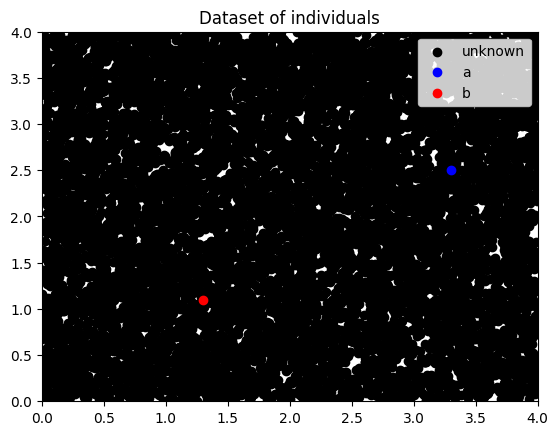

In [11]:
# 定义范围
r1 = 0
r2 = 4

# 生成随机点
points = (r1 - r2) * torch.rand((10000, 2)) + r2
# torch.rand((10000, 2)) 生成一个形状为 (10000, 2) 的张量，其值在 [0, 1) 之间。
# (r1 - r2) * torch.rand((10000, 2)) + r2 将随机值转换到 [r1, r2) 范围内。具体来说，这里会将随机值缩放到 [0, 4) 范围内。
points[-1] = torch.tensor([3., 3.]) # 将最后一个点的坐标设置为 [3, 3]
points[-2] = torch.tensor([1., 1.]) # 将倒数第二个点的坐标设置为 [1, 1]

points_a = torch.tensor([3., 3.])
points_b = torch.tensor([1., 1.])

a = ltn.Constant(torch.tensor([3., 3.])) # a点对应的LTN常量
b = ltn.Constant(torch.tensor([1., 1.])) # b点对应的LTN常量

fig, ax = plt.subplots()
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)
ax.scatter(points[:,0], points[:,1], color="black", label="unknown")
ax.scatter(point_a[0], point_a[1], color="blue", label="a")
ax.scatter(point_b[0], point_b[1], color="red", label="b")
ax.set_title("Dataset of individuals")
plt.legend();

In the following, we define a data loader which takes as input the entire dataset and returns batches of data points
fetched from the dataset. It is possible to decide a batch size and whether to shuffle(打乱、混洗) data.

Then, as anticipated before, it is enough to add some lines of code that iterate(迭代) over the batches and ground the variables with the new data points contained in the batches.


以下是内容的中文翻译：

接下来，我们定义一个数据加载器（`DataLoader`），它将整个数据集作为输入并返回从数据集中获取的数据点批次。可以选择批次大小以及是否对数据进行随机打乱。

然后，如前所述，只需添加几行代码来迭代这些批次，并使用批次中包含的新数据点来绑定变量。

In [15]:
# 相关的解释在3.md的## 4中
# we define C again to re-initialize its weights # 我们再次定义C以重新初始化其权重
# C = ltn.Predicate(ModelC()) # 原来的写法会报错
C = ltn.Predicate(ModelC().to(ltn.device))

# data loader which creates the batches # 数据加载器，用于创建批次
class DataLoader:
    def __init__(self,
                 dataset,
                 batch_size=1,
                 shuffle=True):
        self.data = dataset # 从这个类的具体实现可以发现，这个输入的dataset的类型可以是任意的，只要是可以切片的类型即可。（更准确来说，只要有这个类的实现中所用到的方法即可）
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(self.data.shape[0] / self.batch_size))

    def __iter__(self):
        n = self.data.shape[0]
        idxlist = list(range(n))
        if self.shuffle:
            np.random.shuffle(idxlist) # shuffle方法是numpy软件包的random软件包的mtrand模块中RandomState类的方法。可以直接通过np.random命名空间调用，因为，在random软件包的__init__方法中，有`from .mtrand import *`

        for _, start_idx in enumerate(range(0, n, self.batch_size)):
            end_idx = min(start_idx + self.batch_size, n) # 计算批次的结束索引，确保不会超过数据集的大小 n
            # 前面的操作，拿到了一个批次的索引（这个批次的开始索引和结束索引），接下来就是根据这个批次的索引，从数据集中取出对应的数据点
            batch_points = self.data[idxlist[start_idx:end_idx]] # batch_points的类型和data的类型是一样的

            yield batch_points # 返回当前批次的数据点，暂停函数的执行，等待下一次调用。
            # yield 关键字用于定义生成器函数，可以在函数中返回一个值，同时保留函数的执行状态。当再次调用函数时，可以从上次返回的 yield 语句处继续执行。

train_loader = DataLoader(points, 512)

# by default, SatAgg uses the pMeanError # 默认情况下，SatAgg使用pMeanError
sat_agg = ltn.fuzzy_ops.SatAgg()

# we need to learn the parameters of the predicate C # 我们需要学习谓词C的参数
optimizer = torch.optim.Adam(C.parameters(), lr=0.001)

for epoch in range(100): # 迭代100次，每次迭代都是一个epoch，epoch就是对整个数据集的一次遍历
    # range(100)返回的类型是range，返回一个range类的实例化对象，这个对象是可迭代的，或者说是一个迭代器，或者说是一个可迭代对象。因为range类实现了__iter__方法。
    for (batch_idx, (batch_points)) in enumerate(train_loader): # 到这，需要看前面的md块的内容，以及这里要具体问一下。”逐步详细逐渐深入剖析这个代码块，包括其中的python语法细节“。还有gpt关于这个代码块的第一次解释。
        x1 = ltn.Variable("x1", batch_points)
        x2 = ltn.Variable("x2", batch_points)
        optimizer.zero_grad()
        loss = 1. - sat_agg(
            C(a, l_a),
            C(b, l_b),
            Forall([x1, x2, l], Implies(Sim(x1, x2), Equiv(C(x1, l), C(x2, l))))
        )
        loss.backward()
        optimizer.step()
    if epoch%10 == 0:
        print("Epoch %d: Sat Level %.3f "%(epoch, 1 - loss.item()))

print("Training finished at Epoch %d with Sat Level %.3f" %(epoch, 1 - loss.item()))

Epoch 0: Sat Level 0.603 
Epoch 10: Sat Level 0.847 
Epoch 20: Sat Level 0.943 
Epoch 30: Sat Level 0.950 
Epoch 40: Sat Level 0.949 
Epoch 50: Sat Level 0.948 
Epoch 60: Sat Level 0.949 
Epoch 70: Sat Level 0.948 
Epoch 80: Sat Level 0.948 
Epoch 90: Sat Level 0.950 
Training finished at Epoch 99 with Sat Level 0.949


It is possible to observe that just after 20 epochs, LTN has learned to correctly classify the examples.

Let's see some plot as we did for the previous example.

As shown, LTN has learned how to correctly classify the data points. Also, it is possible to observe that there are some points
in the middle which are more difficult to classify. This is intuitive since their distance from points $a$ and $b$ is similar, so LTN
does not know which is the correct class to assign to them.

当然，以下是您提供内容的中文翻译：

经过20个周期后，可以观察到，LTN已经学会了正确分类这些示例。

让我们像前面的例子一样看看一些图表。

如图所示，LTN已经学会了如何正确分类数据点。此外，可以看到中间有一些点比较难以分类。这很直观，因为这些点与点$a$和$b$的距离相似，所以LTN不知道应该将它们分配到哪个正确的类别。

In [17]:
# yield语法学习
# yield 关键字用于定义生成器函数，可以在函数中返回一个值，同时保留函数的执行状态。当再次调用函数时，可以从上次返回的 yield 语句处继续执行。
# 相应的这个函数的返回值类型就是一个生成器对象，类型是generator
def generate_numbers():
    for i in range(5):
        yield i

gen = generate_numbers() # 这个函数的返回值是一个生成器对象，类型是generator
print("type(gen):\n", type(gen)) # <class 'generator'>
for num in gen:
    print(num)
# 输出:
# 0
# 1
# 2
# 3
# 4


type(gen):
 <class 'generator'>
0
1
2
3
4


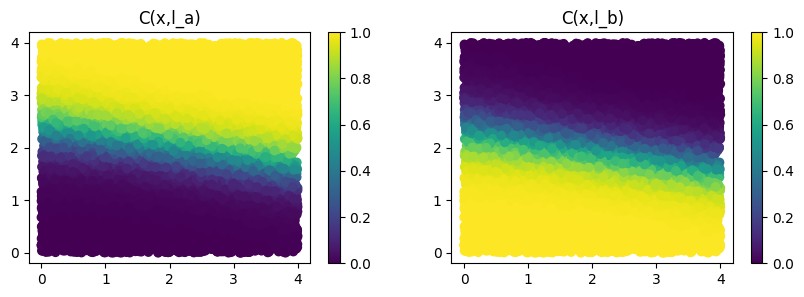

In [16]:
x1 = ltn.Variable("x1", points)
x2 = ltn.Variable("x2", points)
fig = plt.figure(figsize=(10, 3))
fig.add_subplot(1, 2, 1)
# plt.scatter(x1.value[:, 0], x1.value[:, 1], c=C(x1, l_a).value.detach().numpy(), vmin=0, vmax=1)
plt.scatter(x1.value.detach().cpu()[:, 0], x1.value.detach().cpu()[:, 1], c=C(x1, l_a).value.detach().cpu().numpy(), vmin=0, vmax=1)
plt.title("C(x,l_a)")
plt.colorbar()
fig.add_subplot(1, 2, 2)
# plt.scatter(x1.value[:, 0], x1.value[:, 1], c=C(x1, l_b).value.detach().numpy(), vmin=0, vmax=1)
plt.scatter(x1.value.detach().cpu()[:, 0], x1.value.detach().cpu()[:, 1], c=C(x1, l_b).value.detach().cpu().numpy(), vmin=0, vmax=1)
plt.title("C(x,l_b)")
plt.colorbar()
plt.show();